# Implementation of different versions of the benefit difference fairness function

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.consequential_learning import train
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_results_over_lambdas

## The parameters used by the the original authors  

In [2]:
dim_x = 1
training_parameters = {
    'keep_collected_data': False,
    'use_sensitve_attributes': False,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    #'fairness_rate':1000,
    'fraction_protected':0.5,
    'num_test_samples': 2000,
    'bias': True,
    'benefit_value_function': demographic_parity
}
def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

dim_theta = dim_x + 1 if training_parameters['bias'] else dim_x
training_parameters['theta'] = [-3.5, 0.6]
training_parameters['feature_map'] = IdentityFeatureMap(dim_theta)
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']
training_parameters['utility_value_function'] = util_func


## Training loop

In [3]:
result_list = []
def log_result(result):
    result_list.append(result)

def train_single(training_parameters, lamb):
    training_parameters["fairness_rate"] = lamb

    for utility, benefit_delta in train(**training_parameters):
        pass

    return utility, benefit_delta

def train_multiple(training_parameters, iterations_per_lambda, number_of_lambdas=50):
    mean_utilities = []
    max_utilities = []
    min_utilities = []
    mean_benefit_differences = []
    max_benefit_differences = []
    min_benefit_differences = []
    lambdas = []

    for i, lamb in enumerate(np.logspace(-1, 5, base=10, endpoint=True, num=number_of_lambdas)):
        global result_list
        lambdas.append(lamb)
        benefit_deltas = []
        utilities = []
        print("Current Lambda: {}".format(lamb))
        
        # multithreaded runs of training
        pool = mp.Pool(mp.cpu_count())
        for j in range(1, iterations_per_lambda+1):
            pool.apply_async(train_single, args=(training_parameters, lamb), callback = log_result) 
        pool.close()
        pool.join()
        
        results = np.array(result_list)
        result_list = []
        benefit_deltas = results[:,0]
        utilities = results[:,1]

        mean_utilities.append(utilities.mean())
        max_utilities.append(utilities.max())
        min_utilities.append(utilities.min())
        mean_benefit_differences.append(benefit_deltas.mean())
        max_benefit_differences.append(benefit_deltas.max())
        min_benefit_differences.append(benefit_deltas.min())

        # plot_results_over_lambdas(mean_utilities, max_utilities, min_utilities, mean_benefit_differences, max_benefit_differences, min_benefit_differences, lambdas, "results_iter_{}.png".format(i))
    
    plot_results_over_lambdas(mean_utilities, max_utilities, min_utilities, mean_benefit_differences, max_benefit_differences, min_benefit_differences, lambdas, "results_final.png")

## Correct Benefit Difference

Current Lambda: 0.1
Current Lambda: 0.46415888336127786
Current Lambda: 2.1544346900318834
Current Lambda: 10.0
Current Lambda: 46.41588833612777
Current Lambda: 215.44346900318823
Current Lambda: 1000.0
/home/fkretschmar/Documents/master-thesis/src/policy.py:301: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/fkretschmar/Documents/master-thesis/src/policy.py:301: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/fkretschmar/Documents/master-thesis/src/policy.p

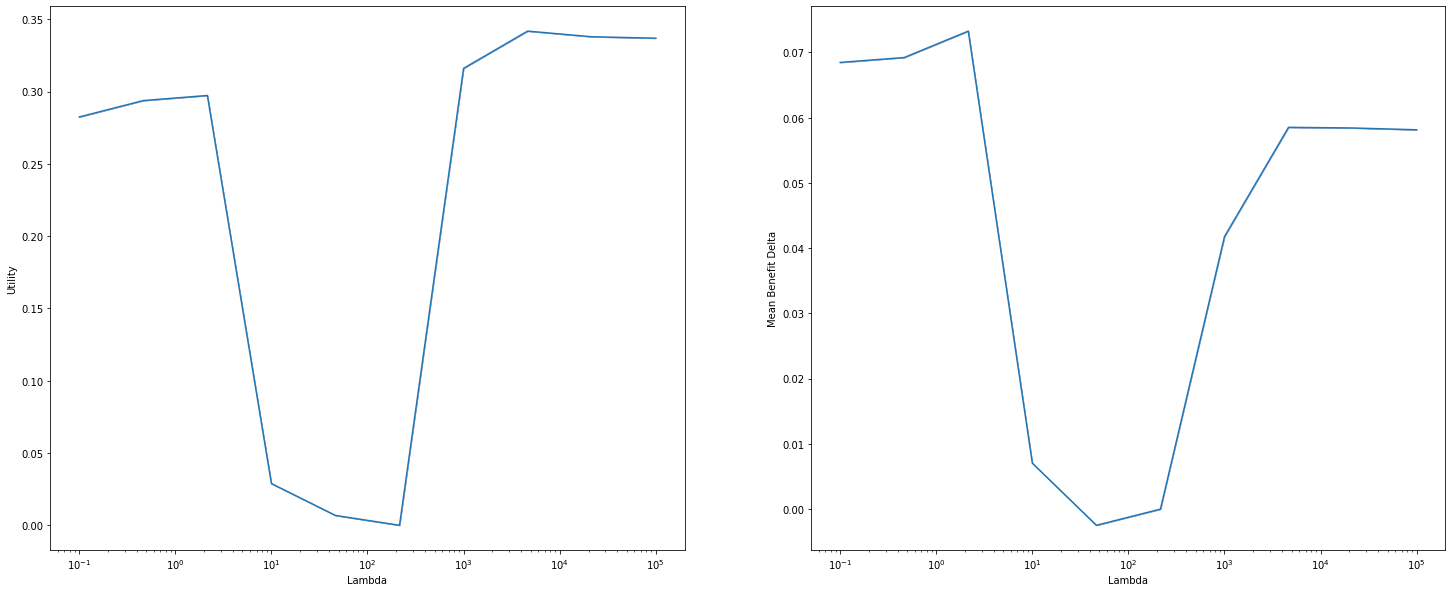

In [5]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)
    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)

    benefit_grad = benefit * phi/denominator

    if ips_weights is not None:
        #benefit *= ips_weights
        benefit_grad *= ips_weights
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters['fairness_function'] = fairness_function

train_multiple(training_parameters, iterations_per_lambda=5, number_of_lambdas=10)